In [21]:
using POMDPs
using POMDPTools
using QuickPOMDPs
using MCTS
using POMDPSimulators
using Distributions
using LinearAlgebra
using D3Trees
using Random
using Plots

# Parameters

In [22]:
# Dimensions
max_progress = 10
max_power = 50
max_h2o = 50
max_o2 = 50
max_food = 50

# Uncertainties
p_mission_regression = 0.05
p_power_fail = 0.02
p_water_loss = 0.02
p_food_loss = 0.02
p_no_mission_progress = 0.05

# Resource consumption
consumed_power = -2 # generated
consumed_h2o = 1
consumed_o2 = 1
consumed_food = 1

1

In [23]:
# Define all possible states and actions (with constraints)
# [progress, power, h2o, o2, food]
indexed = LinearIndices((max_progress, max_power, max_h2o, max_o2, max_food))
states = 1:indexed[max_progress, max_power, max_h2o, max_o2, max_food]

basic_actions = [
      CartesianIndex(1, -3, 0, 0, 0), # make mission progress
      CartesianIndex(0, -2, 5, 0, 0), # make water 
      CartesianIndex(0, -2, -1, 5, 0), # make oxygen
      CartesianIndex(0, -2, -1, -1, 5), # make food
      CartesianIndex(0, 0, 0, 0, 0) # do nothing
] 
consumed = CartesianIndex(0, consumed_power, consumed_h2o, consumed_o2, consumed_food)
actions = [action - consumed for action in basic_actions]

5-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, -1, -1, -1, -1)
 CartesianIndex(0, 0, 4, -1, -1)
 CartesianIndex(0, 0, -2, 4, -1)
 CartesianIndex(0, 0, -2, -2, 4)
 CartesianIndex(0, 2, -1, -1, -1)

In [24]:
# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]
function inbounds(state, action)
    for i in 1:length(state)
        if ((state[i] + action[i]) < 1 || (state[i] + action[i]) > state_maxes[i])
            return false
        end
    end
    return true
end

function clamp_state(state)
    for i in 1:length(state)
        state[i] = clamp(state[i], 1, state_maxes[i])
    end
    return state
end

clamp_state (generic function with 1 method)

In [25]:
# Is terminal?
function isterminal(s)
    return CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s][1] == max_progress
end

# Transition function
function transition(s, a)
    p_nominal = 1 - p_no_mission_progress - p_water_loss - p_power_fail - p_mission_regression 
    p = [p_no_mission_progress, p_water_loss, p_power_fail, p_mission_regression, p_nominal]

    svec = CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
    svec = collect(Tuple(svec))
    a = collect(Tuple(a))
    if !inbounds(svec, a)
        return SparseCat([s,], [1,])
    else
        spvec_no_mission_progress = svec

        spvec_water_loss = svec + a
        spvec_water_loss[3] = 1 # lose all water

        spvec_power_fail = svec + a
        spvec_power_fail[2] = 1 # lose all energy

        spvec_mission_regression = svec + a
        spvec_mission_regression[1] = spvec_mission_regression[1] - 1 # mission setback

        spvec_nominal = svec + a

        spvec = [spvec_no_mission_progress, spvec_water_loss, spvec_power_fail, spvec_mission_regression, spvec_nominal]
    end
    
    sp = []
    for i in 1:length(p)
        push!(sp, indexed[CartesianIndex(Tuple(clamp_state(spvec[i])))])
    end
    return SparseCat(sp, p)
    
end

# Reward function
function reward(s, a)
    svec = CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
    spvec = svec + a
    if spvec[1] == max_progress
        r = 1000
    elseif !inbounds(svec, a) # If invalid action
        r = -1e9
    else
        r = -1
    end
    return r
end

reward (generic function with 1 method)

In [26]:
function generate_mdp(initialstate, states=states, actions=actions, discount=0.95, isterminal=isterminal, transition=transition, reward=reward)
    return QuickMDP(
        states = states,
        actions = actions,
        initialstate = initialstate,
        discount = discount,
        isterminal = isterminal,
        transition = transition,
        reward = reward
    )
end

generate_mdp (generic function with 7 methods)

In [27]:
function simulate_mcts(initialstate, iter, rollout_iter, depth, replan_interval)

    history = []
    s = initialstate
    push!(history, s)
    policy = rollout_policy(s, rollout_iter, depth)

    for i in 1:iter

        if isterminal(s)
            break
        end

        if i % replan_interval == 0 # Replan
            policy = rollout_policy(s, rollout_iter, depth)
        end

        a = action(policy, s)
        T = transition(s, a)
        s = rand(T)
        push!(history, s)

    end

    return history

end

function rollout_policy(state, rollout_iter, depth)
    mdp = generate_mdp(state)
    solver = MCTSSolver(n_iterations=rollout_iter, depth=depth, exploration_constant=5.0, enable_tree_vis=true)
    policy = solve(solver, mdp)
    return policy
end

rollout_policy (generic function with 1 method)

In [28]:
initialstate = indexed[1, 5, 5, 5, 5]

5102041

In [33]:
history = simulate_mcts(initialstate, 100, 1000, 100, 2)

96-element Vector{Any}:
  5102041
  3951041
  2678041
  1405041
  1405041
  6354041
  5203041
  3930041
  2779041
  1628041
        ⋮
 19029067
 17756067
 16605067
 15332067
 15332067
 14059067
 12783558
 11508049
 10232540

In [34]:
history = [CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s] for s in history]

96-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, 5, 5, 5, 5)
 CartesianIndex(1, 5, 3, 9, 4)
 CartesianIndex(1, 5, 7, 8, 3)
 CartesianIndex(1, 5, 11, 7, 2)
 CartesianIndex(1, 5, 11, 7, 2)
 CartesianIndex(1, 5, 9, 5, 6)
 CartesianIndex(1, 5, 7, 9, 5)
 CartesianIndex(1, 5, 11, 8, 4)
 CartesianIndex(1, 5, 9, 12, 3)
 CartesianIndex(1, 5, 7, 16, 2)
 ⋮
 CartesianIndex(7, 7, 9, 12, 16)
 CartesianIndex(7, 7, 13, 11, 15)
 CartesianIndex(7, 7, 11, 15, 14)
 CartesianIndex(7, 7, 15, 14, 13)
 CartesianIndex(7, 7, 15, 14, 13)
 CartesianIndex(7, 7, 19, 13, 12)
 CartesianIndex(8, 6, 18, 12, 11)
 CartesianIndex(9, 5, 17, 11, 10)
 CartesianIndex(10, 4, 16, 10, 9)

In [35]:
history_progress = [s[1] for s in history]
history_power = [s[2] for s in history]
history_h2o = [s[3] for s in history]
history_o2 = [s[4] for s in history]
history_food = [s[5] for s in history]

96-element Vector{Int64}:
  5
  4
  3
  2
  2
  6
  5
  4
  3
  2
  ⋮
 16
 15
 14
 13
 13
 12
 11
 10
  9

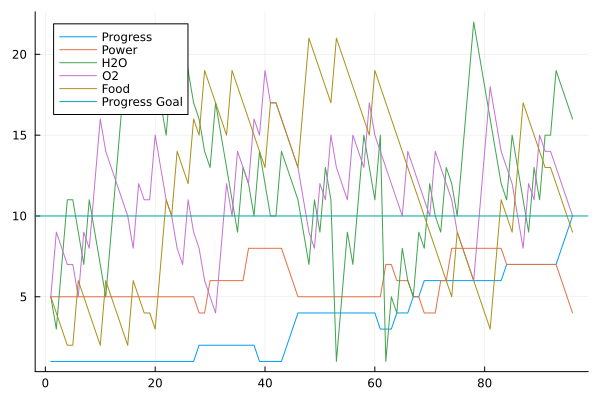

In [38]:
p1 = plot()
plot!(
    p1,
    1:length(history),
    [history_progress history_power history_h2o history_o2 history_food],
    label=["Progress" "Power" "H2O" "O2" "Food"]
)
hline!(p1, [max_progress], label="Progress Goal")